In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import itertools as it

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression
import warnings
np.warnings.filterwarnings('ignore')

In [2]:
# Loading test and train data
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [3]:
# Separate into test and train
y_train = train.target
X_train = train.drop("target", axis = 1)

y_test = test.target
X_test = test.drop('target', axis = 1)

X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [4]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train_columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train_columns)

In [5]:
# Create a model object - not trained yet
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

LogisticRegression()

In [6]:
# Use coef_ to return the coefficients - only log reg inference you can do with sklearn
print(logreg.coef_) 

[[ 9.95587324e-02 -1.07662109e+00  1.06472158e-01  4.66479321e-01
  -2.44813594e-01  1.40768772e-01 -1.55557226e-01  5.47311070e-01
   4.08772998e-01  3.55602963e-01  1.70434026e-01  3.00039216e-01
  -5.40290651e-01 -3.61193638e-01  1.27554019e-01  1.52792543e-01
  -2.90211619e-02  2.97121881e-01 -3.48683275e-01 -2.14480358e-01
  -1.13655106e-01 -2.04768940e+00  1.10713469e-01  6.87753191e-02
   4.31129570e-01 -1.84516750e-01  3.89832680e-02 -2.48991214e-01
   4.28958728e-01  6.99375639e-02  3.39222785e-01  2.42615866e-01
  -1.41639100e-01 -1.01319089e-01  2.59042021e-01 -2.90039178e-02
   2.43790151e-01  1.32267212e-02 -4.16829989e-01  9.66702789e-02
  -8.02383506e-03 -1.64081409e-02  1.48742291e-01  4.16657224e-02
  -3.23214000e-01  2.70126600e-01  1.49100680e-01  1.97697580e-01
  -2.36377578e-01  1.46225721e-01 -1.64001635e-02 -1.18825586e-01
  -1.29835035e-01 -2.20508390e-01 -1.92699302e-01 -1.66672373e-01
  -1.00597253e-01  2.72217496e-02  6.24088147e-02 -7.30400913e-02
   7.79029

In [7]:
# Get the predicted classes first
y_pred = logreg.predict(X_test)

# Use the predicted and true classes for accuracy
print(accuracy_score(y_pred, y_test)*100) 

86.17


In [9]:
# Use .score with test predictors and response to get the accuracy
# Implements the same thing under the hood
print(logreg.score(X_test, y_test)*100)  

86.17


In [11]:
#Computing the predicted probability for the observation to belong to the positive class (y=1);
#The 2nd column in the output of predict_proba() consists of the probability of the observation to 
#belong to the positive class (y=1)
y_pred_prob = logreg.predict_proba(X_test)[:,1] 

#Using the predicted probability computed above to find ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print(auc(fpr, tpr))# AUC of ROC

0.9133629808254775


Precision:  0.7793948678667177
Recall:  0.7160450387051372


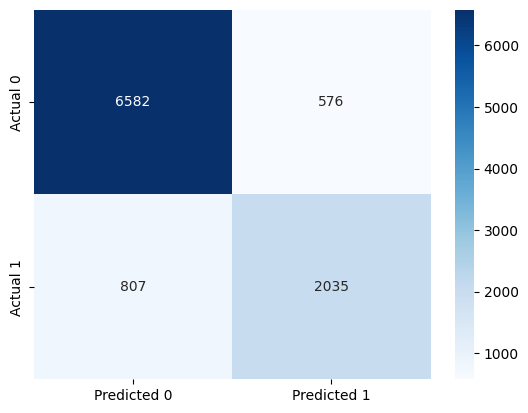

In [12]:
#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

In [14]:
# Finding cross-validation error for trees
param_grid = {    
    'C': 10**np.linspace(-3.5, 1),
}

cv = StratifiedKFold(n_splits=5)

grid_search_model = GridSearchCV(LogisticRegression(random_state = 1), param_grid = param_grid, 
                                       scoring = ['accuracy', 'recall'], refit = 'recall', n_jobs=-1, verbose=True,
                                       cv=cv)

grid_search_model.fit(X_train, y_train)

# make the predictions
y_pred = grid_search_model.predict(X_test)

print('Train accuracy : %.3f'%grid_search_model.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search_model.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search_model.best_score_)

print('Best params for recall')
print(grid_search_model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Train accuracy : 0.910
Test accuracy : 0.864
Best accuracy Through Grid Search : 0.724
Best params for recall
{'C': 0.014225293134853698}


In [16]:
tree = LogisticRegression(random_state=1, C = 0.014225293134853698).fit(X_train, y_train)

cross_val_ypred = cross_val_predict(LogisticRegression(random_state=1, C = 0.014225293134853698), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)

  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

In [26]:
metrics.loc[(metrics.accuracy>=85) & (metrics.recall>85), :].sort_values(by = 'recall', ascending = False).iloc[0,:]

threshold     0.196000
accuracy     85.050000
recall       87.700744
Name: 196, dtype: float64

In [25]:
metrics.loc[(metrics.accuracy>=85) & (metrics.recall>85), :].sort_values(by = 'accuracy', ascending = False).iloc[0,:]

threshold     0.24200
accuracy     86.08000
recall       85.19389
Name: 242, dtype: float64

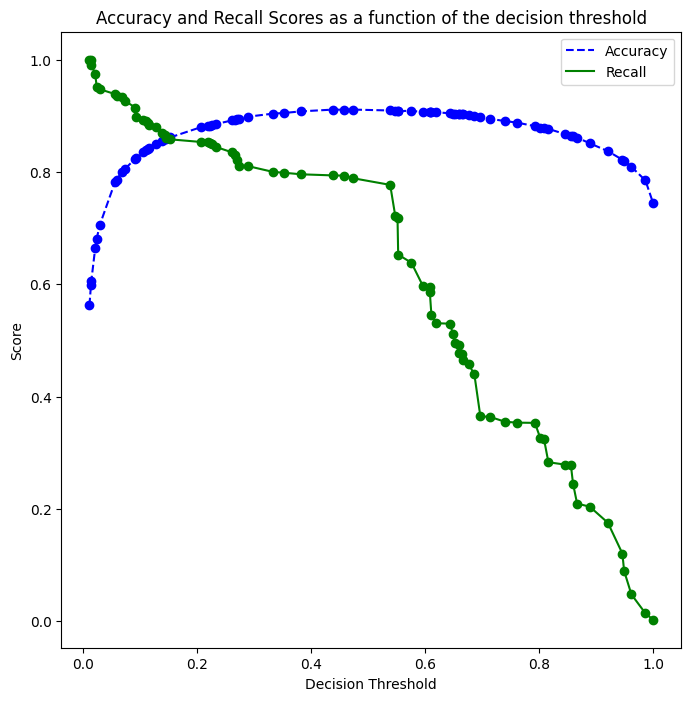

In [19]:
tree = LogisticRegression(random_state=1, C = 0.014225293134853698).fit(X_train, y_train)


tree.fit(X_train, y_train)

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []

for t in thresholds:
  y_pred_prob = tree.predict_proba(X_train)[:,1]
  y_pred = y_pred_prob > t
  y_pred = y_pred.astype(int)
  accuracy = (accuracy_score(y_pred, y_train))
  accuracy_list.append(accuracy)

def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
  plt.figure(figsize=(8,8))
  plt.title("Accuracy and Recall Scores as a function of the decision threshold")
  plt.plot(thresholds, accuracy_list, "b--", label = "Accuracy")
  plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall")
  plt.plot(thresholds, accuracy_list, 'o', color = 'blue')
  plt.plot(thresholds, recalls[:-1], 'o', color = 'green')
  plt.ylabel('Score')
  plt.xlabel('Decision Threshold')
  plt.legend(loc='best')
  plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

### **Maximal Recall Models**

Accuracy:  87.6
ROC-AUC:  0.9645203438151867
Precision:  0.6896850621207743
Recall:  0.9349784567175872


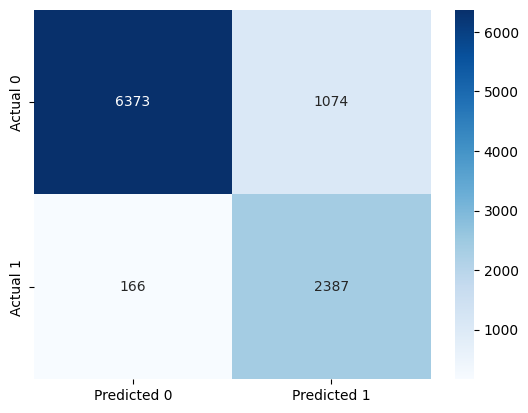

In [27]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.196000

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  84.49
ROC-AUC:  0.9235026669568889
Precision:  0.6746955345060893
Recall:  0.8771991555242786


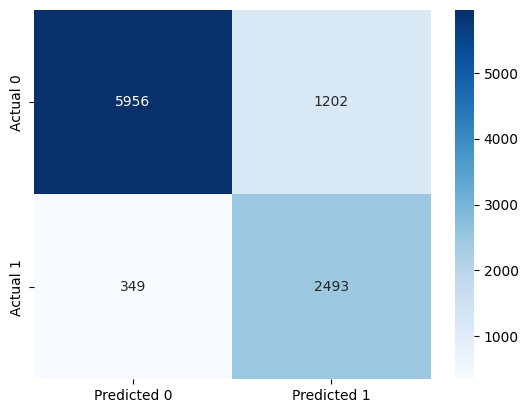

In [28]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.196000

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### **Maximal Accuracy Model**

Accuracy:  88.73
ROC-AUC:  0.9645203438151867
Precision:  0.7192496924969249
Recall:  0.9161770466118292


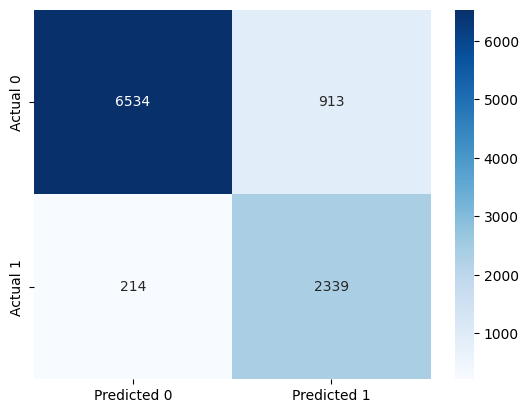

In [29]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.24200

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  85.56
ROC-AUC:  0.9235026669568889
Precision:  0.7019064124783362
Recall:  0.8550316678395496


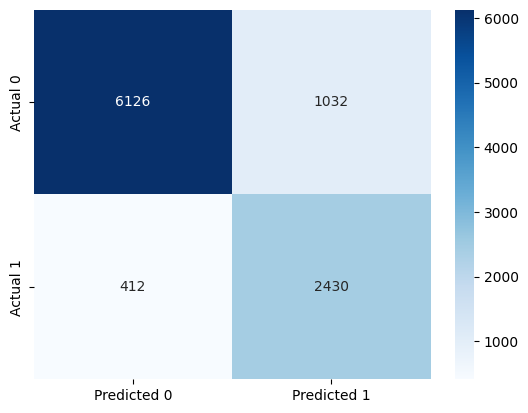

In [30]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.24200

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');